This notebook plays around with the visualization options of the Python interface of Somoclu. First, we import the necessary modules:

In [1]:
import somoclu
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

Then we generate and plot some random data in three categories:

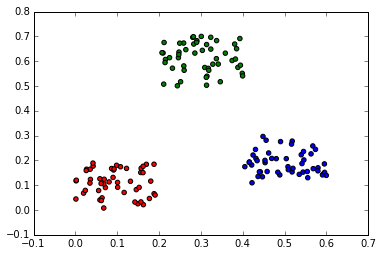

In [2]:
c1 = np.random.rand(50, 2)/5
c2 = (0.2, 0.5) + np.random.rand(50, 2)/5
c3 = (0.4, 0.1) + np.random.rand(50, 2)/5
data = np.float32(np.concatenate((c1, c2, c3)))
colors = [ "red" ] * 50
colors.extend(["green"] * 50)
colors.extend(["blue"] * 50)
plt.scatter(data[:,0], data[:,1], c=colors)
labels = range(150)

We train Somoclu with default parameter settings, asking for a large map that qualifies as an emergent self-organizing map for this data:

In [3]:
nSomX, nSomY = 140, 100
som = somoclu.Somoclu(nSomX, nSomY, data=data)
som.train(nEpoch=30)

We plot the component planes of the trained codebook of the ESOM:

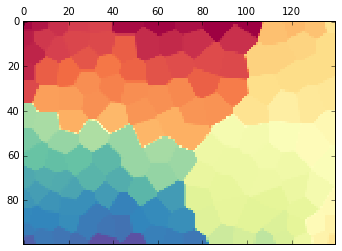

In [4]:
som.view_component_planes()

Finally we plot the U-Matrix:

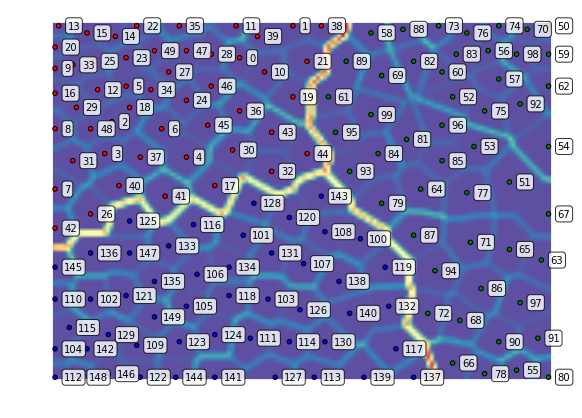

In [5]:
som.view_umatrix(colormap="Spectral_r", bestmatches=True, 
                  bestmatchcolors=colors, labels=labels)

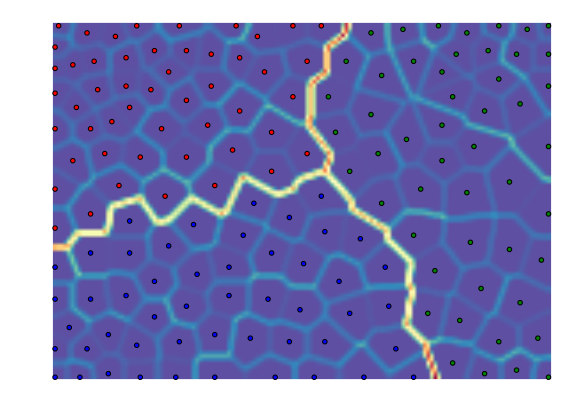

In [6]:
som.view_umatrix(colormap="Spectral_r", bestmatches=True, 
                  bestmatchcolors=colors)

ValueError: operands could not be broadcast together with shapes (100,) (60,) 

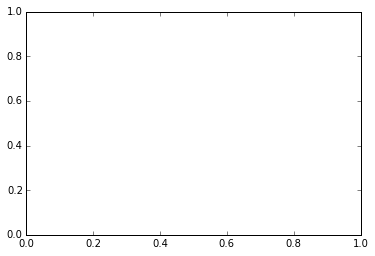

In [3]:
nSomX, nSomY = 100, 60
som = somoclu.Somoclu(nSomX, nSomY, data=data)
som.train(nEpoch=30, gridType="hexagonal")
som.view_umatrix()